# Model Definition

In [38]:
#An Implementation of Diffusion Network Model
#Oringinal source: https://github.com/acids-ircam/diffusion_models

import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(400, 1024, n_steps)
        self.lin2 = ConditionalLinear(1024, 1024, n_steps)
        self.lin3 = ConditionalLinear(1024, 1024, n_steps)
        self.lin4 = ConditionalLinear(1024, 1024, n_steps)
        self.lin5 = ConditionalLinear(1024, 1024, n_steps)
        self.lin6 = ConditionalLinear(1024, 1024, n_steps)
        self.lin7 = ConditionalLinear(1024, 1024, n_steps)
        self.lin8 = nn.Linear(1024, 400)
        self.bn = nn.BatchNorm1d(1024)
    
    def forward(self, x, y):
        x = F.relu(self.lin1(x, y))
        x = self.bn(x)
        x = F.relu(self.lin2(x, y) + x)
        x = self.bn(x)
        x = F.relu(self.lin3(x, y) + x)
        x = self.bn(x)
        x = F.relu(self.lin4(x, y) + x)
        x = self.bn(x)
        x = F.relu(self.lin5(x, y) + x)
        x = self.bn(x)
        x = F.relu(self.lin6(x, y) + x)
        x = self.bn(x)
        x = F.relu(self.lin7(x, y) + x)
        x = self.bn(x)
        return self.lin8(x)

# EMA

In [2]:
# Exponential Moving Average Class
# Orignal source: https://github.com/acids-ircam/diffusion_models


class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

# Loss Function for Diffusion Model

In [3]:
# Loss Function for Diffusion Model
# Original Source: https://github.com/acids-ircam/diffusion_models

import torch
import numpy as np

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    
    return out.reshape(*reshape)

def q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt, device):
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    
    t = torch.tensor([t])
    t = t.to(device)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    # print("*" * 20)
    # print((1 / extract(alphas, t, x).sqrt()).shape) # [1, 1]
    # print((x - (eps_factor * eps_theta)).shape) # [8110, 400]
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape, n_steps, alphas, betas, one_minus_alphas_bar_sqrt, device):
    # device = "cuda: 2" if torch.cuda.is_available() else "cpu"
    
    cur_x = torch.randn(shape)
    # x_seq = [cur_x.cpu()]
    cur_x = cur_x.to(device)
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, alphas, betas, one_minus_alphas_bar_sqrt, device)
        # x_seq.append(cur_x.cpu())
    return cur_x

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt ,noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

def loss_variational(model, x_0,alphas_bar_sqrt, one_minus_alphas_bar_sqrt,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

def noise_estimation_loss(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps, device):
    # device = "cuda: 2" if torch.cuda.is_available() else "cpu"
    
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    t = t.to(device)
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0).to(device)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

# Gene Expression Diffusion Tuning

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
# from helper_plot import hdr_plot_style
import torch
from utils import * 

In [5]:
# Data loading

FLE_COORDS_PATH ='data/fle_coords.txt'
FULL_DS_PATH = 'data/ExprMatrix.h5ad'
VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'data/cell_days.txt'
GENE_SETS_PATH = 'data/gene_sets.gmx'
GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
CELL_SETS_PATH = 'data/cell_sets.gmt'

coord_df = pd.read_csv(FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(CELL_DAYS_PATH, index_col='id', sep='\t')

adata = wot.io.read_dataset(FULL_DS_PATH, obs=[CELL_DAYS_PATH])

pcadata = np.load("adata_dim_400.npy")
pcadata.shape

(251203, 400)

In [6]:
days = adata.obs['day'].unique()[:-1]
indices = [adata.obs['day'].isin([day]) for day in days]
adatalist = [adata[index] for index in indices]

pcadatalist = [pcadata[index] for index in indices]

In [7]:
# days = np.array([ 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8., 8.25,
#                 8.5 ,  8.75,  9.  ,  9.5 , 10.  , 10.5 , 11.  , 11.5 , 12.  ,
#                 12.5 , 13.  , 13.5 , 14.  , 14.5 , 15.  , 15.5 , 16.  , 16.5 ,
#                 17.  , 17.5 , 18.  ])

In [34]:
num_steps = 200
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.01)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [9]:
def q_x(x_0, t, device, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    x_0 = x_0.to(device)
    t = t.to(device)
    noise = noise.to(device)
    alphas_t = extract(alphas_bar_sqrt.cpu(), t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt.cpu(), t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [10]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
# # from helper_plot import hdr_plot_style
# import torch
# from utils import * 

# # hdr_plot_style()
# swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
# swiss_roll = swiss_roll[:, [0, 2]]/10.0

# s_curve, _= make_s_curve(10**4, noise=0.1)
# s_curve = s_curve[:, [0, 2]]/10.0

# moons, _ = make_moons(10**4, noise=0.1)

# data = s_curve.T
# #dataset = torch.Tensor(data.T).float()


# fig,axes = plt.subplots(1,3,figsize=(20,5))

# axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
# axes[0].axis('off')

# data = swiss_roll.T
# axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
# axes[1].axis('off')
# #dataset = torch.Tensor(data.T).float()

# data = moons.T
# axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
# axes[2].axis('off')
# dataset = torch.Tensor(data.T).float()

In [11]:
# dataset

NameError: name 'dataset' is not defined

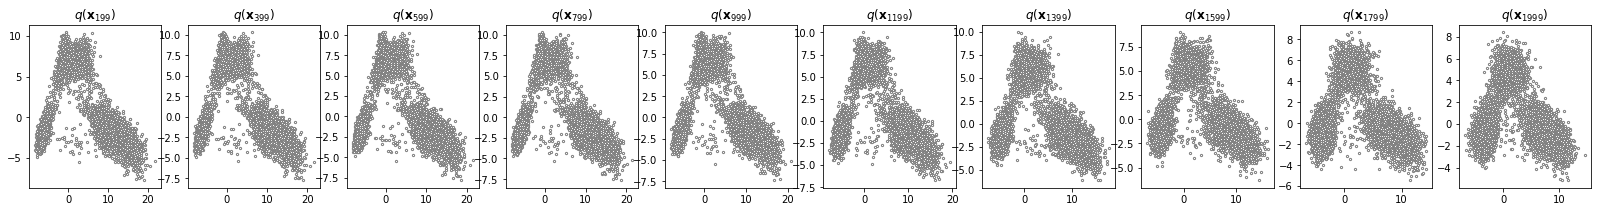

In [35]:
from sklearn.decomposition import PCA
from itertools import product

dataset = torch.tensor(pcadatalist[36])
pca = PCA(n_components=2)
pca.fit(q_x(dataset, torch.tensor([0]), device="cpu"))

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 20 + 19]), device="cpu")
    pca_q_i = pca.transform(q_i)
    axs[i].scatter(pca_q_i[:, 0], pca_q_i[:, 1],color='white',edgecolor='gray', s=5);
    # axs[i].set_axis_off(); 
    axs[i].set_title('$q(\mathbf{x}_{'+str(i*200 + 199)+'})$')

# fig, axs = plt.subplots(3, 13, figsize=(39, 9))
# plt.title("schedule=linear, n_timesteps=1000, start=1e-5, end=0.008")
# config = "schedule=linear, n_timesteps=1000, start=1e-5, end=0.008"

# for i, j in product(torch.arange(3), torch.arange(13)):
#     tmp_dataset = torch.tensor(pcadatalist[i * 13 + j])
#     pca.fit(q_x(tmp_dataset, torch.tensor([999]), device="cpu"))
#     q_i = q_x(tmp_dataset, torch.tensor([999]), device="cpu")
#     pca_q_i = pca.transform(q_i)
#     axs[i, j].scatter(pca_q_i[:, 0], pca_q_i[:, 1],color='white',edgecolor='gray', s=5);
#     axs[i, j].set_axis_off(); axs[i, j].set_title('$q(\mathbf{x}_{time\_index\_'+str((i*13+j).item())+'})$')
    
# plt.savefig("figs/" + config + ".png")
    


In [ ]:
# torch.abs(torch.mean(q_i, 0)).mean()
# torch.var(q_i, 0)
# rdm = torch.randn(q_i.size())
# torch.var(rdm, 0)

In [ ]:
# pca.transform(model.bn.forward(torch.zeros((2, 1024)).to("cuda:0")).detach().cpu())

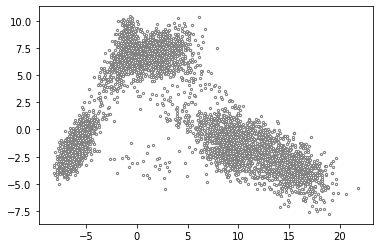

In [13]:
q_i = q_x(dataset, torch.tensor([0]), device="cpu")
pca_q_i= pca.transform(q_i)
plt.scatter(pca_q_i[:, 0], pca_q_i[:, 1],color='white',edgecolor='gray', s=5)

# Training of Diffusion Model, Generation and Verification of virtual cell gene expressions

Here we take time index 36 as an example since the original distribution is far from gaussian.

## Diffusion Model Training

100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


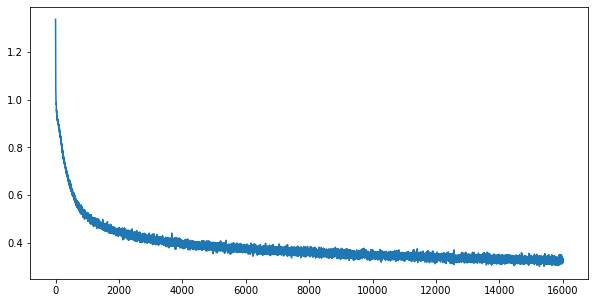

In [16]:
import torch.optim as optim
from tqdm import trange
from sklearn.decomposition import PCA
import scipy.stats as stats


device = "cuda:0" if torch.cuda.is_available() else "cpu"

# dataset = torch.tensor(pcadatalist[36])
dataset = dataset.to(device)


# fig, axs = plt.subplots(1, 10, figsize=(28, 3))
# for i in range(10):
#     q_i = q_x(dataset, torch.tensor([i * 100 + 99]), device="cpu")
#     pca_q_i = pca.fit_transform(q_i)
#     axs[i].scatter(pca_q_i[:, 0], pca_q_i[:, 1],color='white',edgecolor='gray', s=5);
#     axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*100+99)+'})$')
# pca = PCA(n_components=2)
# pca.fit(q_x(dataset, torch.tensor([num_steps - 1]), device="cpu"))

model = ConditionalModel(num_steps)
model = model.to(device)

alphas = alphas.to(device)
betas = betas.to(device)

alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.0)
ema.register(model)
# Batch size
batch_size = 512
loss_hist = []
wd = []
for t in trange(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        # print(indices)
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps, device)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        loss_hist.append(loss.item())
    # Print loss
    # if (t % 100 == 0):
        # print(loss)
        # x_seq = p_sample_loop(model, dataset.shape, num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device)
        # print(x_seq)
        # fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        # for i in range(1, 11):
        #     cur_x = x_seq[i * 200].detach().cpu()
        #     # wd.append(stats.wasserstein_distance(dataset.cpu(), cur_x))
        #     # print(cur_x.shape)
        #     cur_x = pca.transform(cur_x)
        #     # print(cur_x.shape)
        #     axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
        #     # axs[i-1].set_axis_off(); 
        #     axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*200)+'})$')
        #     # tmp_sample = [i.detach().cpu() for i in x_seq][i * 100]
            
        # del x_seq
        
        # cur_x = p_sample_loop(model, dataset.shape, num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device)
        # pca_cur_x = pca.transform(cur_x)
        # plt.scatter(pca_cur_x[:, 0], pca_cur_x[:, 1])
 
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)

In [ ]:
# x_seq = [i.cpu() for i in x_seq]
# x_seq[0]
# [i.detach().cpu() for i in x_seq][0 * 100].size()
# dataset.shape
# del sim

In [ ]:
dataset.shape
# torch.Size([50, 400])

torch.Size([8110, 400])

In [ ]:
import seaborn as sns
sns.set()

# ground_truth = pca.transform(dataset.cpu())

# sim = p_sample_loop(model, dataset.shape, num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device)
# sim_pca = pca.transform(sim.detach().cpu())
# plt.scatter(sim_pca[:, 0], sim_pca[:, 1], color="red", edgecolors='red', s=5)
# plt.scatter(ground_truth[:, 0], ground_truth[:, 1],color='green',edgecolor='green', s=5)

# plt.set_axis_off()

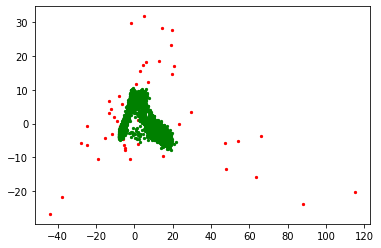

In [18]:
ground_truth = pca.transform(dataset.cpu())

sim = p_sample_loop(model, torch.Size([50, 400]), num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device)
sim_pca = pca.transform(sim.detach().cpu())
plt.scatter(sim_pca[:, 0], sim_pca[:, 1], color="red", edgecolors='red', s=5)
plt.scatter(ground_truth[:, 0], ground_truth[:, 1],color='green',edgecolor='green', s=5)

# plt.set_axis_off()

In [24]:
sim_pca = None

for _ in range(40):
    sim = p_sample_loop(model, torch.Size([50, 400]), num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device)
    if sim_pca is None: 
        sim_pca = sim.detach().cpu()
    else:
        sim_pca = torch.cat((sim_pca, sim.detach().cpu()))
    # plt.scatter(sim_pca[:, 0], sim_pca[:, 1], color="red", edgecolors='red', s=5)



/tmp/ipykernel_2567722/2852105798.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pca.fit(torch.cat((sim_pca, torch.tensor(dataset)), 0))


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_cat)

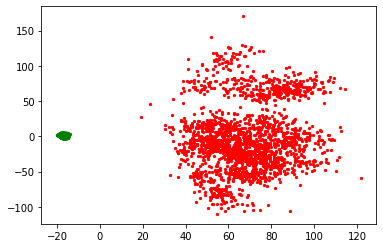

In [26]:
pca = PCA(n_components=2)
pca.fit(torch.cat((sim_pca, dataset.cpu()), 0))
sim_res = pca.transform(np.array(sim_pca))
tru_res = pca.transform(dataset.cpu())

plt.scatter(sim_res[:, 0], sim_res[:, 1], color="red", edgecolors='red', s=5)
plt.scatter(tru_res[:, 0], tru_res[:, 1],color='green',edgecolor='green', s=5)


In [29]:
torch.min(dataset, dim=1)[0].mean()

tensor(-5.7493, device='cuda:0')

In [37]:
torch.min(sim_pca, dim=1)[0].mean()

tensor(-39.7357)

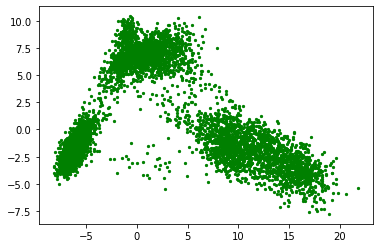

In [20]:
plt.scatter(ground_truth[:, 0], ground_truth[:, 1],color='green',edgecolor='green', s=5)


In [ ]:
# num_steps
# ground_truth[:, 0].mean()
dataset.mean(dim=0)

tensor([-1.1027e+00,  3.6657e+00, -4.0220e-01, -4.3802e-01, -2.7593e-01,
         2.2929e-01,  1.5354e-01, -5.7255e-01,  6.3767e-02, -3.9774e-01,
         1.6954e-02,  3.4162e-02,  8.4202e-02,  2.7340e-01, -3.0327e-01,
        -2.5875e-02,  4.3134e-01,  2.5405e-01,  1.5519e-01,  4.3181e-02,
        -1.4007e-01,  2.2871e-01,  1.7728e-01,  6.1383e-02, -1.3635e-01,
         1.1756e-01,  3.8539e-02, -2.7223e-02, -1.2164e-01,  5.4268e-03,
         4.6064e-03, -6.7025e-03, -2.2090e-01,  1.8845e-02,  8.9127e-02,
         1.4792e-01,  8.7032e-02, -3.2017e-02,  1.8964e-02, -6.6203e-02,
         9.2809e-02, -1.9510e-01, -2.3219e-01, -1.1434e-01,  4.1505e-02,
        -4.1623e-02, -3.5094e-02,  1.2398e-01, -1.0926e-01, -2.4964e-02,
        -1.2627e-02,  4.3864e-02, -1.4924e-02,  9.3726e-02, -8.6349e-02,
         7.4294e-02,  1.4229e-01, -3.0750e-02,  1.0584e-03,  1.3960e-01,
        -1.5261e-02, -3.3298e-02, -9.8655e-03, -5.8874e-03, -4.9510e-02,
         2.6856e-03,  9.7223e-02, -3.4843e-02, -5.2

In [ ]:
sim.mean(dim=0)

tensor([  0.6203,  -0.7458,  -7.8560, -17.0238,  -5.5459,   0.4506,  -6.8798,
          7.5324, -10.9304,  -7.8308,   6.5895, -10.3553, -13.2151,  20.9228,
         16.1387,  -7.2933,  -0.7522,  13.7296,   5.5948,  -2.4344,   7.0302,
         -4.0336,  12.7147,   3.9291,   6.0986,   1.1737,  -2.4176,  13.0204,
         13.7363,  -5.4057,   1.2676,  23.3355,  10.1871,  17.1462,   4.2731,
         10.4404,   4.4761,   1.3388, -35.4007,   1.7014, -20.6240,  -1.5489,
         16.5324,   7.7508,   7.0405,  -3.8234, -18.0491,  -7.8225,  -1.7470,
          3.6528, -13.2305,   5.0933,  22.0536,  15.2463,  -6.7893,   5.3162,
          6.0629,  -3.5000,   6.5490,   7.3864,  -6.7106,   1.4041,   9.3420,
         13.5724,  -4.8234,   1.7761,   4.0368, -11.8076,   1.1104,  -1.2815,
         -0.4375,   9.7016,  -9.8170, -29.2207, -12.2679,  -6.2346,  -6.5547,
          5.4344,  -8.2636,  21.7112, -28.0127,  -6.4577,  -3.3894, -12.1314,
         -8.4061,  14.0081,  10.3285,  -9.0276, -11.8881,   7.06

In [ ]:
del sim

In [ ]:
dataset

tensor([[-7.0649,  5.2176, -1.3848,  ..., -0.0281,  0.0915,  0.0823],
        [-7.5994,  4.3442, -2.6339,  ..., -0.3368, -0.1338,  0.2656],
        [-7.2791,  4.9447, -2.3628,  ..., -0.0954, -0.0888,  0.0693],
        ...,
        [-7.0766,  6.0095, -1.0571,  ...,  0.2908, -0.4318,  0.1368],
        [-7.7680,  4.7139, -1.6997,  ...,  0.0322, -0.0923, -0.0968],
        [-7.3343,  3.8130, -2.1704,  ...,  0.0135, -0.0770, -0.3576]],
       device='cuda:0')

In [ ]:
plt.scatter(ground_truth[:, 0], ground_truth[:, 1],color='green',edgecolor='green', s=5)
# plt.scatter(sim_pca[:, 0], sim_pca[:, 1], color="red", edgecolors='red', s=5)

NameError: name 'ground_truth' is not defined

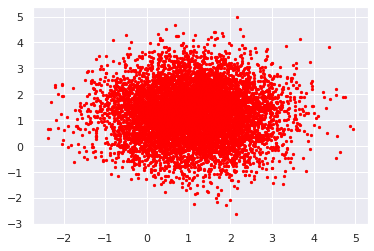

In [ ]:
plt.scatter(sim_pca[:, 0], sim_pca[:, 1], color="red", edgecolors='red', s=5)


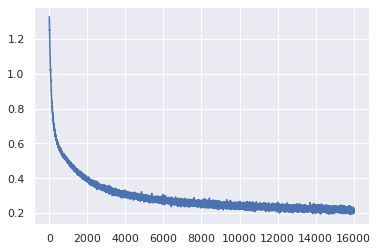

In [ ]:
plt.plot(loss_hist)


In [ ]:
import scipy.stats as stats

# del x_seq
x_seq = p_sample_loop(model, dataset.shape, num_steps, alphas, betas, one_minus_alphas_bar_sqrt, device, 100)
wd = []
for i in range(len(x_seq)):
    wd.append(stats.wasserstein_distance(x_seq), dataset)
    
plt.plot(wd)

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 79.10 GiB total capacity; 39.05 GiB already allocated; 25.88 MiB free; 39.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Generation

## Verification